In [1]:
import pandas as pd 
import numpy as np

from pymutspec.draw import plot_mutspec192, plot_mutspec12
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import spatial

In [4]:
cox1_mut = pd.read_csv('../data/counted_codons_cox1.csv')
cytb_mut = pd.read_csv('../data/counted_codons_cytb.csv')

In [8]:
counted_codons_cox1 = cox1_mut.drop("Gene", axis=1)
counted_codons_cytb = cytb_mut.drop("Gene", axis=1)

_counted_codons_cox1 = counted_codons_cox1.melt(["Species", "ExpectedObserved"], counted_codons_cox1.columns[2:], var_name="Mut")
_counted_codons_cytb = counted_codons_cytb.melt(["Species", "ExpectedObserved"], counted_codons_cytb.columns[2:], var_name="Mut")

mutations_cox1 = _counted_codons_cox1.pivot(index=["Species", "Mut"], columns="ExpectedObserved", values="value").reset_index()
mutations_cytb = _counted_codons_cytb.pivot(index=["Species", "Mut"], columns="ExpectedObserved", values="value").reset_index()



mutations_cox1["RawMutSpec"] = (mutations_cox1["Observed"] / mutations_cox1["Expected"]).fillna(0)
mutations_cox1["RawMutSpec"] = mutations_cox1["RawMutSpec"].replace(np.inf, 0)
mutations_cytb["RawMutSpec"] = (mutations_cytb["Observed"] / mutations_cytb["Expected"]).fillna(0)
mutations_cytb["RawMutSpec"] = mutations_cytb["RawMutSpec"].replace(np.inf, 0)


rawsum_df_cox1 = mutations_cox1.groupby("Species").RawMutSpec.sum().reset_index().rename(columns={"RawMutSpec": "RawMutSpecSum"})
rawsum_df_cytb = mutations_cytb.groupby("Species").RawMutSpec.sum().reset_index().rename(columns={"RawMutSpec": "RawMutSpecSum"})

mutspecs_cox1 = pd.merge(mutations_cox1, rawsum_df_cox1, on="Species")
mutspecs_cox1["MutSpec"] = mutspecs_cox1["RawMutSpec"] / mutspecs_cox1["RawMutSpecSum"]
mutspecs_cytb = pd.merge(mutations_cytb, rawsum_df_cytb, on="Species")
mutspecs_cytb["MutSpec"] = mutspecs_cytb["RawMutSpec"] / mutspecs_cytb["RawMutSpecSum"]

mutspecs_cytb.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec
0,Abbottina_obtusirostris,A[A>C]A,0.0,0.0,0.0,1.088889,0.0
1,Abbottina_obtusirostris,A[A>C]C,0.0,0.0,0.0,1.088889,0.0
2,Abbottina_obtusirostris,A[A>C]G,0.0,0.0,0.0,1.088889,0.0
3,Abbottina_obtusirostris,A[A>C]T,0.0,0.0,0.0,1.088889,0.0
4,Abbottina_obtusirostris,A[A>G]A,8.0,0.0,0.0,1.088889,0.0


### CHANGED TO HEAVY STRAND

In [10]:
def getrevers(mut):
    translator = str.maketrans("ACGT", "TGCA")
    new_mut = mut[-1] + mut[1:-1] + mut[0]
    new_mut = new_mut.translate(translator)
    return new_mut

In [11]:
mutspecs_cox1['Mut'] = mutspecs_cox1.Mut.apply(getrevers)
mutspecs_cox1["MutBase"] = mutspecs_cox1.Mut.str.slice(2, 5)
mutspecs_cox1["Context"] = mutspecs_cox1.Mut.str.get(0) + mutspecs_cox1.Mut.str.get(2) + mutspecs_cox1.Mut.str.get(-1)

mutspecs_cytb['Mut'] = mutspecs_cytb.Mut.apply(getrevers)
mutspecs_cytb["MutBase"] = mutspecs_cytb.Mut.str.slice(2, 5)
mutspecs_cytb["Context"] = mutspecs_cytb.Mut.str.get(0) + mutspecs_cytb.Mut.str.get(2) + mutspecs_cytb.Mut.str.get(-1)


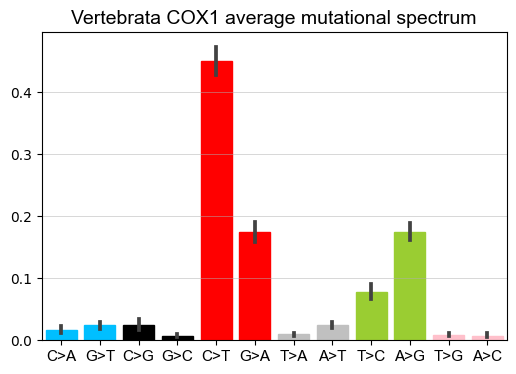

In [12]:
_species_spectra12 = mutspecs_cox1.copy()
_species_spectra12["Mut"] = _species_spectra12["Mut"].str.slice(2,5)
ax = plot_mutspec12(
    _species_spectra12.groupby(["Species", "Mut"]).MutSpec.sum().reset_index(), 
    fontname="Arial", ticksize=11, title="Vertebrata COX1 average mutational spectrum")

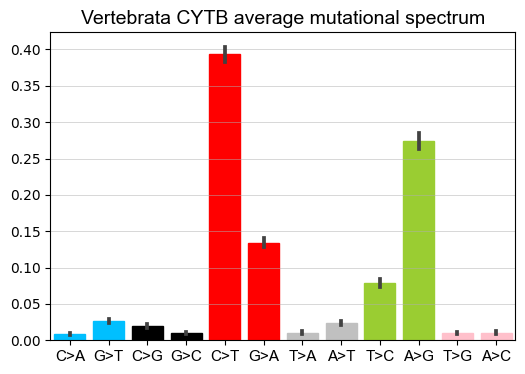

In [13]:
_species_spectra12 = mutspecs_cytb.copy()
_species_spectra12["Mut"] = _species_spectra12["Mut"].str.slice(2,5)
ax = plot_mutspec12(
    _species_spectra12.groupby(["Species", "Mut"]).MutSpec.sum().reset_index(), 
    fontname="Arial", ticksize=11, title="Vertebrata CYTB average mutational spectrum",
    )

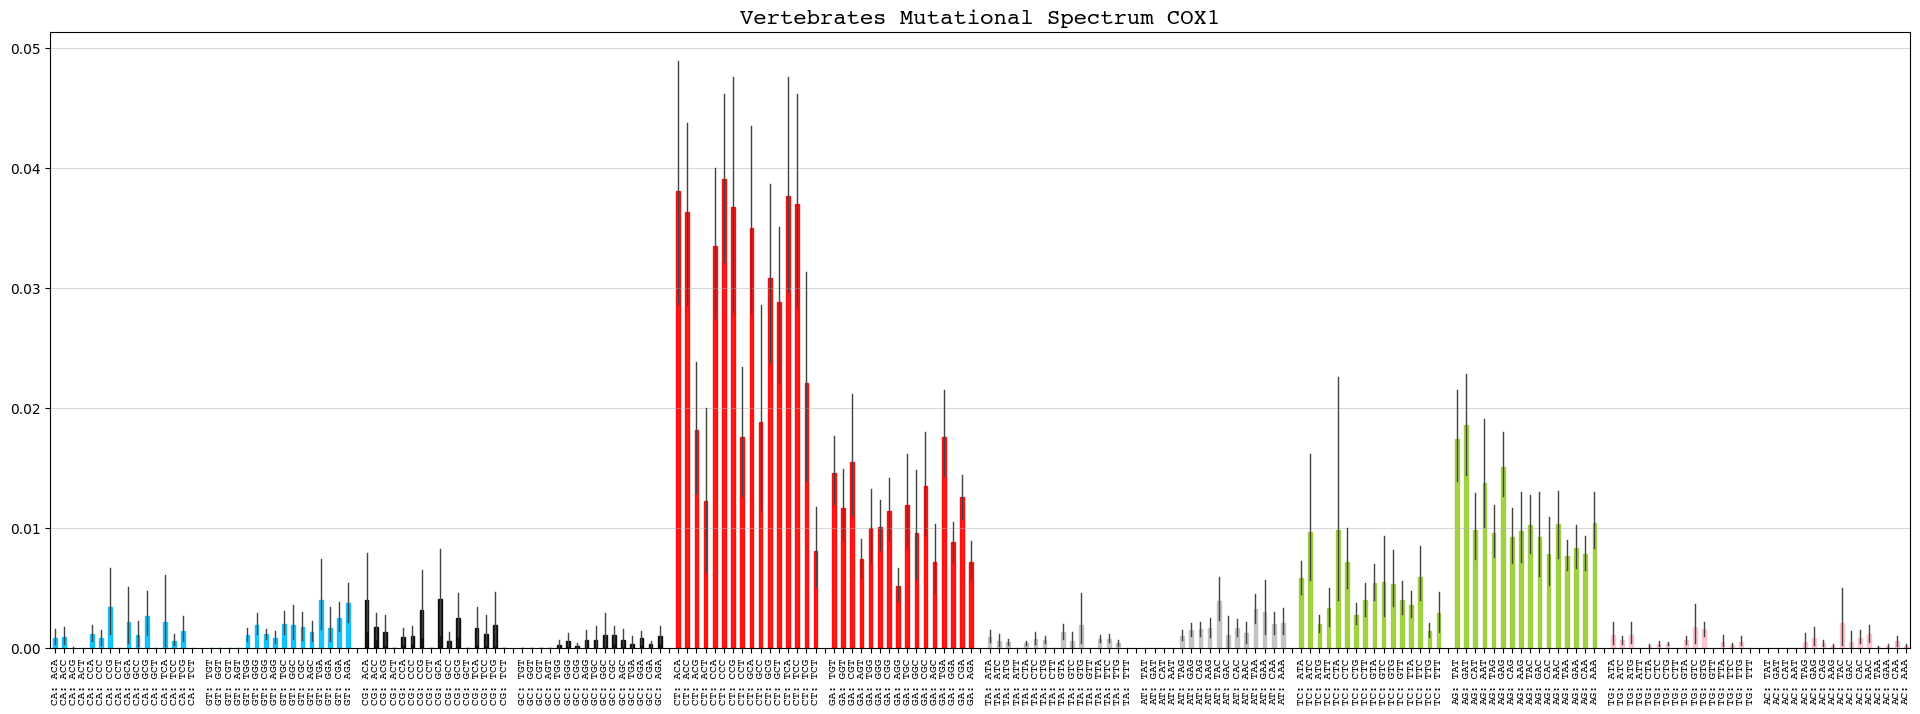

<AxesSubplot:title={'center':'Vertebrates Mutational Spectrum COX1'}>

In [14]:
plot_mutspec192(mutspecs_cox1, title='Vertebrates Mutational Spectrum COX1',
                fontname='Courier', ticksize=8, labels_style='long')

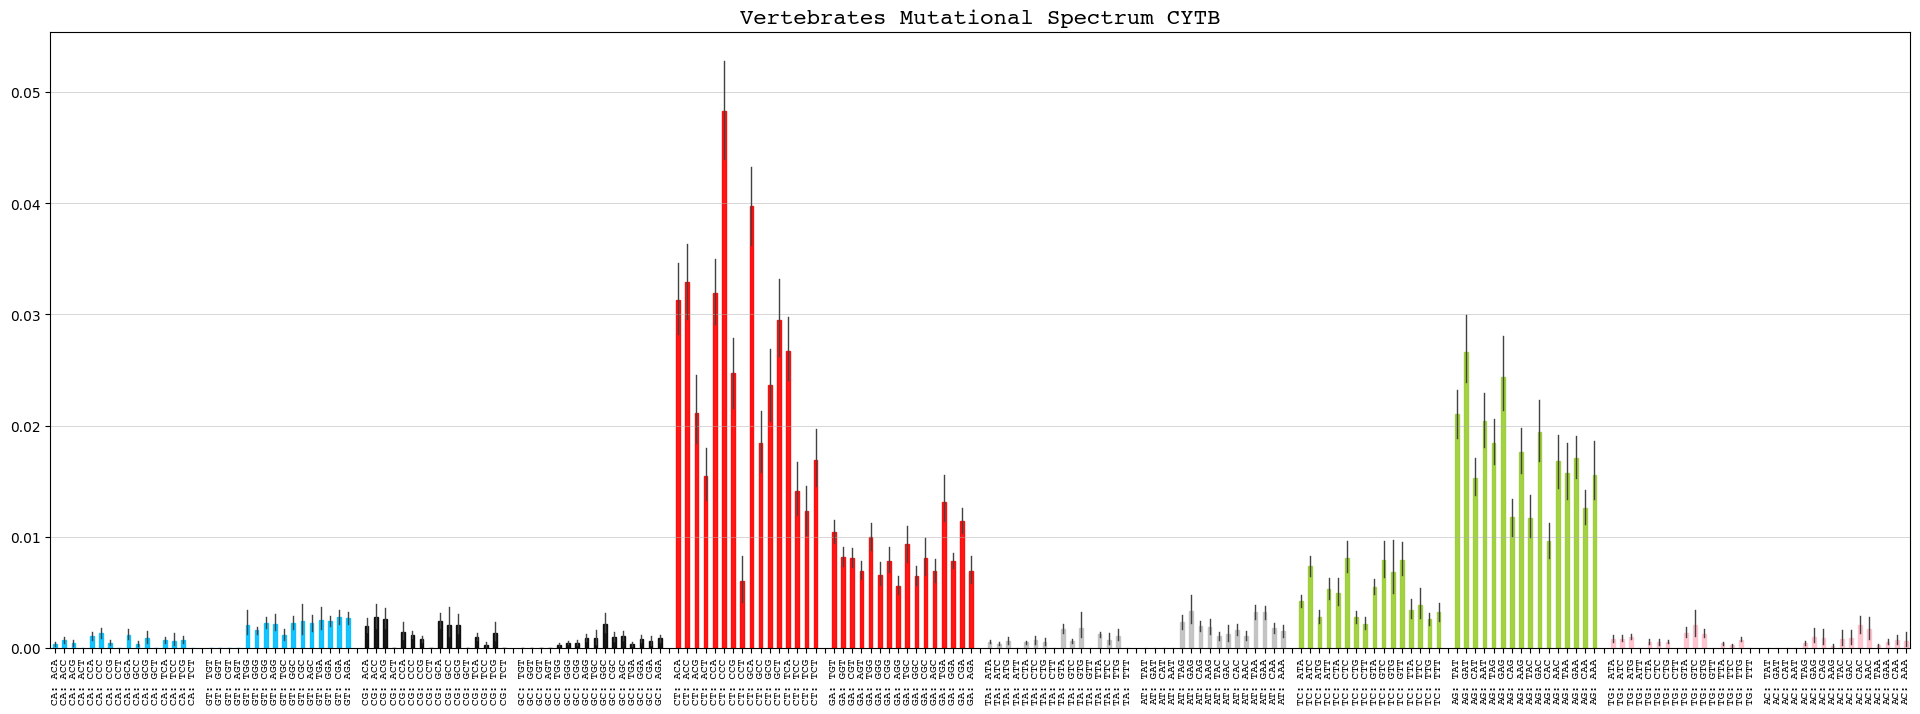

<AxesSubplot:title={'center':'Vertebrates Mutational Spectrum CYTB'}>

In [15]:
plot_mutspec192(mutspecs_cytb, title='Vertebrates Mutational Spectrum CYTB',
                fontname='Courier', ticksize=8, labels_style='long')